In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
from tqdm import tqdm

import sys
sys.path.append("../src")

from event_selections import *
from data_prep import *
from make_cuts import *
from fitting_functions import *
from pulse_profile_generator import *
from plot_maker import *

In [3]:
pd.set_option('display.max_columns', None)

In [197]:
c_folder="../../data/calibration/"
d_folder="../../data/runData/"
r_n=300

Path("../../plots").mkdir(parents=True, exist_ok=True)
Path("../../plots/run_"+str(r_n)).mkdir(parents=True, exist_ok=True)
p_folder="../../plots/run_"+str(r_n)+"/"

In [198]:
%%time
p,m,r=import_data(c_folder,d_folder, r_n, is_it_pulsed=False)

CPU times: user 12.1 s, sys: 6.28 s, total: 18.4 s
Wall time: 20.7 s


In [199]:
%%time
r=select_bars_with_data(r,p, subtract_pedestal=True, is_it_pulsed=False) #this needs to be run as it's own cell

Number of events: 71416


Initial pedestal-based selection performed.
Events left: 71415


CPU times: user 1.35 s, sys: 781 ms, total: 2.13 s
Wall time: 2.67 s


In [200]:
pulse_df=pd.read_csv(d_folder+"run_"+str(r_n)+"_pulse_problems.csv", index_col="index")

In [201]:
filtered_df=r.drop(["pf_event", "layer", "strip",
                    "pedestal_per_time_sample_std_dev_end0", "pedestal_per_time_sample_std_dev_end1",
                    "adc_mean_end0", "adc_mean_end1"], axis=1)

In [202]:
big_df=filtered_df.merge(pulse_df, left_index=True, right_index=True)

In [203]:
non_TOT=big_df[(big_df["tot_end0"]==0) & (big_df["tot_end1"]==0)]

In [204]:
wavy=non_TOT[non_TOT["problem_type"]=="WAVE"]
late=non_TOT[non_TOT["problem_type"]=="LATE"]
spiky=non_TOT[(non_TOT["problem_type"]=="SPIKE_0") | (non_TOT["problem_type"]=="SPIKE_1")]

In [205]:
wavy_all=big_df[big_df["problem_type"]=="WAVE"]
late_all=big_df[big_df["problem_type"]=="LATE"]
spiky_all=big_df[(big_df["problem_type"]=="SPIKE_0") | (big_df["problem_type"]=="SPIKE_1")]

In [206]:
hand_bins=np.linspace(50,7250,101)

a,_=np.histogram(non_TOT["adc_sum_end0"], bins=hand_bins)
w,_=np.histogram(wavy["adc_sum_end0"], bins=hand_bins)
l,_=np.histogram(late["adc_sum_end0"], bins=hand_bins)
s,_=np.histogram(spiky["adc_sum_end0"], bins=hand_bins)

a_all,_=np.histogram(big_df["adc_sum_end0"], bins=hand_bins)
w_all,_=np.histogram(wavy_all["adc_sum_end0"], bins=hand_bins)
l_all,_=np.histogram(late_all["adc_sum_end0"], bins=hand_bins)
s_all,_=np.histogram(spiky_all["adc_sum_end0"], bins=hand_bins)

wavy_share=w/a
late_share=l/a
spiky_share=s/a

wavy_share_all=w_all/a_all
late_share_all=l_all/a_all
spiky_share_all=s_all/a_all

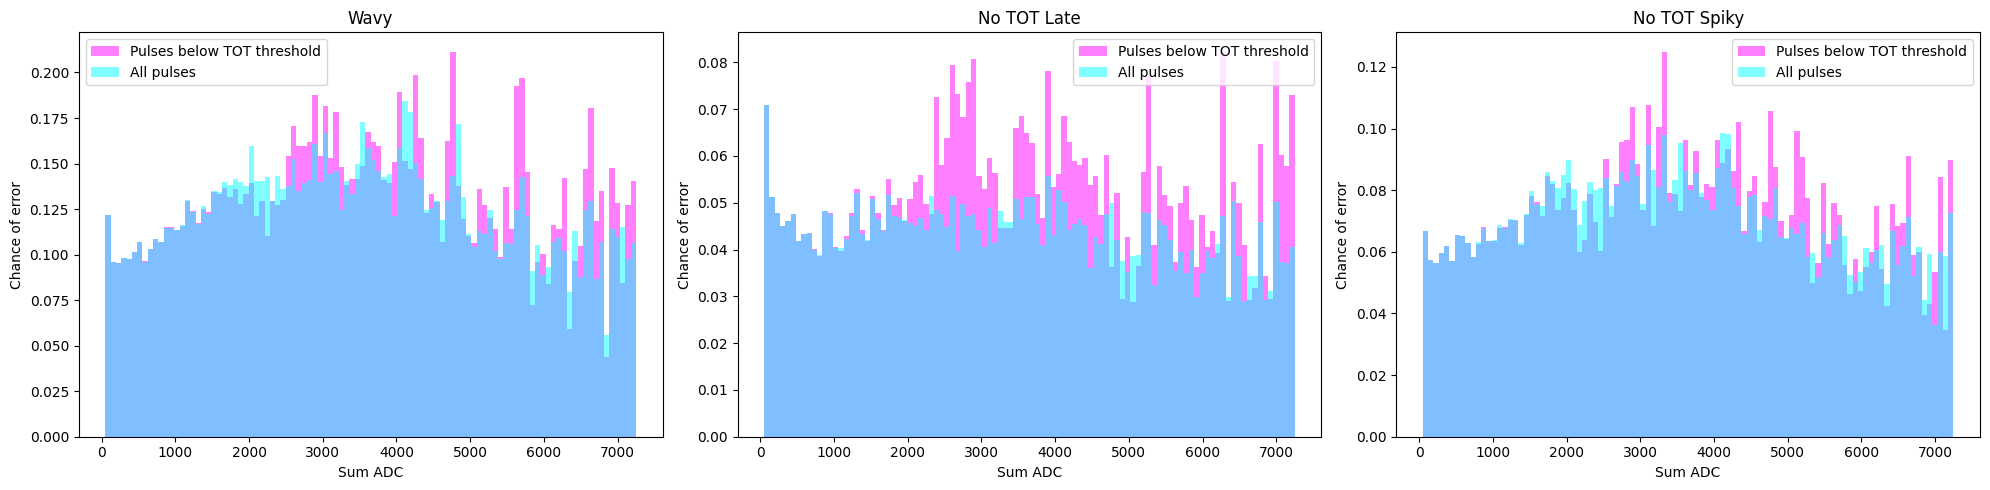

In [207]:
plt.rcParams["figure.figsize"]=(20,5)

plt.subplot(1,3,1)
plt.title("Wavy")
plt.hist(hand_bins[:-1],hand_bins,weights= wavy_share, alpha=0.5, color="magenta", label="Pulses below TOT threshold")
plt.hist(hand_bins[:-1],hand_bins,weights= wavy_share_all, alpha=0.5, color="cyan", label="All pulses")
plt.xlabel("Sum ADC")
plt.ylabel("Chance of error")
plt.legend()

plt.subplot(1,3,2)
plt.title("No TOT Late")
plt.hist(hand_bins[:-1],hand_bins,weights= late_share, alpha=0.5, color="magenta", label="Pulses below TOT threshold")
plt.hist(hand_bins[:-1],hand_bins,weights= late_share_all, alpha=0.5, color="cyan", label="All pulses")
plt.xlabel("Sum ADC")
plt.ylabel("Chance of error")
plt.legend()

plt.subplot(1,3,3)
plt.title("No TOT Spiky")
plt.hist(hand_bins[:-1],hand_bins,weights= spiky_share, alpha=0.5, color="magenta", label="Pulses below TOT threshold")
plt.hist(hand_bins[:-1],hand_bins,weights= spiky_share_all, alpha=0.5, color="cyan", label="All pulses")
plt.xlabel("Sum ADC")
plt.ylabel("Chance of error")
plt.legend()

plt.tight_layout()
plt.show()

In [208]:
big_df.sample(5)

,tot_end0,adc_sum_end0,adc_max_end0,tot_end1,adc_sum_end1,adc_max_end1,layer,bar,event,has_problem,problem_type
1684481,0,335,83,0,238,56,10.0,5.0,67273.0,0,NaN
770824,0,86,32,0,86,30,5.0,3.0,77803.0,0,NaN
1406688,2072,5404,922,477,4406,928,8.0,4.0,3773.0,0,NaN
1430578,0,3804,930,0,3837,924,8.0,4.0,44432.0,0,NaN
842035,0,5328,916,355,5703,916,5.0,5.0,6161.0,0,NaN


In [209]:
events_by_layer=big_df.groupby(["layer"]).count()[["event"]]

wave_chance=big_df[big_df["problem_type"]=="WAVE"].groupby(["layer"]).count()[["event"]]/events_by_layer
late_chance=big_df[big_df["problem_type"]=="LATE"].groupby(["layer"]).count()[["event"]]/events_by_layer
spike0_chance=big_df[big_df["problem_type"]=="SPIKE_0"].groupby(["layer"]).count()[["event"]]/events_by_layer
spike1_chance=big_df[big_df["problem_type"]=="SPIKE_1"].groupby(["layer"]).count()[["event"]]/events_by_layer

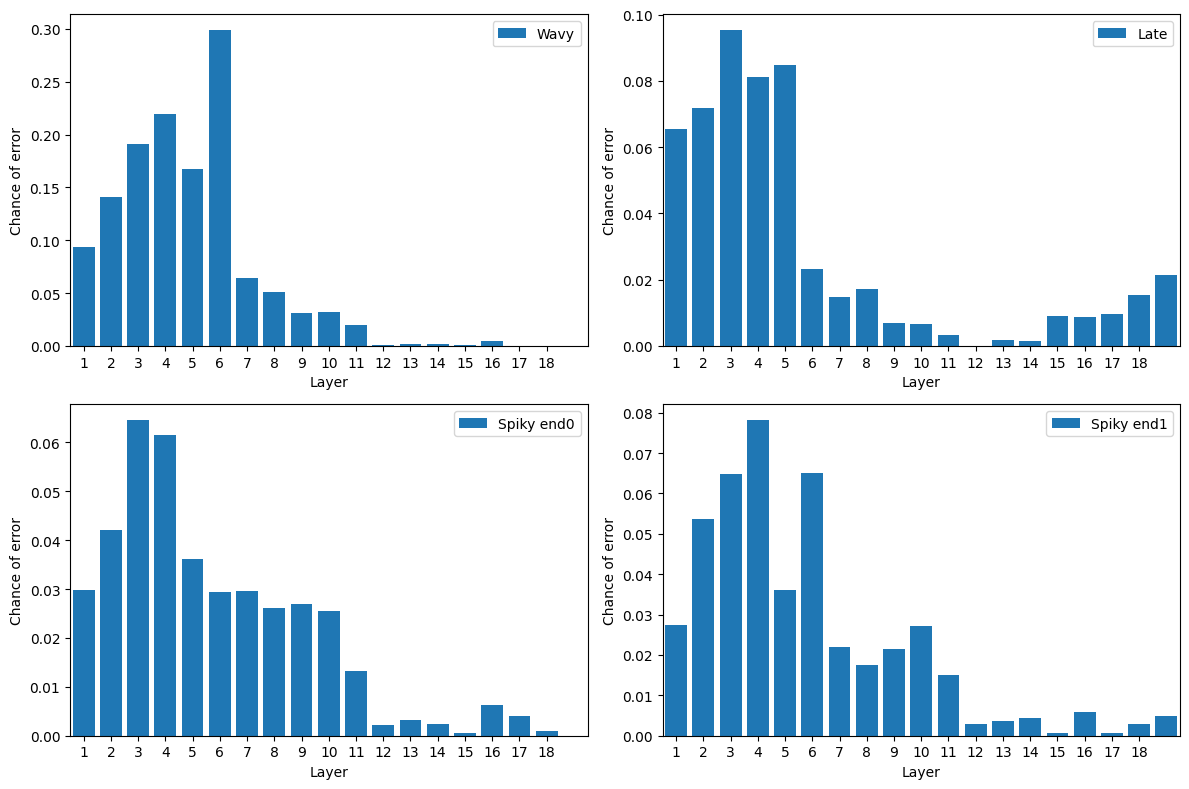

In [210]:
plt.rcParams["figure.figsize"]=(12,8)
plt.subplot(2,2,1)
plt.bar(wave_chance.index,wave_chance["event"], label="Wavy")
plt.xlim(0.5,19.5)
plt.xticks(np.arange(1,19))
plt.xlabel("Layer")
plt.ylabel("Chance of error")
plt.legend(loc="upper right")

plt.subplot(2,2,2)
plt.bar(late_chance.index,late_chance["event"], label="Late")
plt.xlim(0.5,19.5)
plt.xticks(np.arange(1,19))
plt.xlabel("Layer")
plt.ylabel("Chance of error")
plt.legend(loc="upper right")

plt.subplot(2,2,3)
plt.bar(spike0_chance.index,spike0_chance["event"], label="Spiky end0")
plt.xlim(0.5,19.5)
plt.xticks(np.arange(1,19))
plt.xlabel("Layer")
plt.ylabel("Chance of error")
plt.legend(loc="upper right")

plt.subplot(2,2,4)
plt.bar(spike1_chance.index,spike1_chance["event"], label="Spiky end1")
plt.xlim(0.5,19.5)
plt.xticks(np.arange(1,19))
plt.xlabel("Layer")
plt.ylabel("Chance of error")
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()